In [1]:
!pip install -U -q spacy

In [2]:
!spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 96.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [42]:
 import os
 import torch
 import string
 import spacy
 import torch.nn as nn
 import torch.optim as optim
 import torch.nn.functional as F
 import numpy as np
 import pandas as pd
 import random
 import matplotlib.pyplot as plt

 from torch.utils.data import Dataset, DataLoader
 from sklearn.model_selection import train_test_split
 from transformers import AutoTokenizer, AutoModel
 import matplotlib.pyplot as plt
 from torch.nn.utils.rnn import pad_sequence
 from tensorflow.keras.preprocessing.text import Tokenizer
 from tensorflow.keras.preprocessing.sequence import pad_sequences
 from google.colab import drive

# **Data Loading**

''' The dataset has been selected from kaggle named BBC News Summary specifically from the Entertainment Section.  It consists of a collection of plain text (.txt) files, each representing an individual entertainment news article published by the BBC with 386 data for articles and 386 for summaries'''

In [4]:
drive.mount('/content/drive')
articles_path = "/content/drive/MyDrive/SEQSEQ/entertainment"
summaries_path = "/content/drive/MyDrive/SEQSEQ/entertainment_sum"
all_dfs = []

file_names = [f"{i:03d}.txt" for i in range(1, 387)]
articles = []
summaries = []

for file_name in file_names:
    with open(os.path.join(articles_path, file_name), 'r', encoding='utf-8') as f:
        articles.append(f.read())

    with open(os.path.join(summaries_path, file_name), 'r', encoding='utf-8') as f:
        summaries.append(f.read())


data = pd.DataFrame({
    'article': articles,
    'summary': summaries
})



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data.head()

,article,summary
0,Gallery unveils interactive tree\n\nA Christma...,"The messages will be ""unwrapped"" by sculptor R..."
1,Jarre joins fairytale celebration\n\nFrench mu...,Bloom is to be formally presented with the Han...
2,Musical treatment for Capra film\n\nThe classi...,The classic film It's A Wonderful Life is to b...
3,Richard and Judy choose top books\n\nThe 10 au...,"""It was very hard to follow last year's extrem..."
4,Poppins musical gets flying start\n\nThe stage...,Mary Poppins was originally created by author ...


## Data Preprocessing

For data processing I have changed the text to lowercase , removed whitespace , stopwords , tokenized the text and finally lemmitization have been done. The text are padded for same length token for model input

In [6]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")
def basic_preprocess(text):
    text = re.sub(r'\s+', ' ', text.lower()).strip()
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop]
    return tokens


data['article_tokens'] = data['article'].apply(basic_preprocess)
data['summary_tokens'] = data['summary'].apply(basic_preprocess)


In [7]:
file_names = [f"{i:03d}.txt" for i in range(1, 387)]
data['filename'] = file_names
data['line'] = data['article']

print(data[['filename', 'line', 'article_tokens']].head())


  filename                                               line  \
0  001.txt  Gallery unveils interactive tree\n\nA Christma...   
1  002.txt  Jarre joins fairytale celebration\n\nFrench mu...   
2  003.txt  Musical treatment for Capra film\n\nThe classi...   
3  004.txt  Richard and Judy choose top books\n\nThe 10 au...   
4  005.txt  Poppins musical gets flying start\n\nThe stage...   

                                      article_tokens  
0  [gallery, unveils, interactive, tree, christma...  
1  [jarre, joins, fairytale, celebration, french,...  
2  [musical, treatment, capra, film, classic, fil...  
3  [richard, judy, choose, books, 10, authors, sh...  
4  [poppins, musical, gets, flying, start, stage,...  


In [8]:
def lemmatize_token_list(tokens):
    text = ' '.join(tokens)
    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc if token.is_alpha]
    return lemmatized

data['final_article_tokens'] = data['article_tokens'].apply(lemmatize_token_list)
data['final_summary_tokens'] = data['summary_tokens'].apply(lemmatize_token_list)


In [9]:
print(data[['filename', 'final_article_tokens']].head())


  filename                               final_article_tokens
0  001.txt  [gallery, unveil, interactive, tree, christmas...
1  002.txt  [jarre, join, fairytale, celebration, french, ...
2  003.txt  [musical, treatment, capra, film, classic, fil...
3  004.txt  [richard, judy, choose, book, author, shortlis...
4  005.txt  [poppin, musical, get, fly, start, stage, adap...


In [10]:

data['article_text'] = data['final_article_tokens'].apply(lambda tokens: ' '.join(tokens))
data['summary_text'] = data['final_summary_tokens'].apply(lambda tokens: ' '.join(tokens))

article_tokenizer = Tokenizer(oov_token="<OOV>")
summary_tokenizer = Tokenizer(oov_token="<OOV>")

article_tokenizer.fit_on_texts(data['article_text'])
summary_tokenizer.fit_on_texts(data['summary_text'])

article_sequences = article_tokenizer.texts_to_sequences(data['article_text'])
summary_sequences = summary_tokenizer.texts_to_sequences(data['summary_text'])

max_article_len = max(len(seq) for seq in article_sequences)
max_summary_len = max(len(seq) for seq in summary_sequences)
max_len = max(max_article_len, max_summary_len)

padded_articles = pad_sequences(article_sequences, maxlen=max_len, padding='post')
padded_summaries = pad_sequences(summary_sequences, maxlen=max_len, padding='post')


In [11]:
print("Article Sequences: ", article_sequences[:1])
print("Summary Sequences: ", summary_sequences[:1])


Article Sequences:  [[1036, 1846, 1225, 1485, 156, 1485, 103, 1847, 1226, 1846, 73, 961, 210, 282, 1036, 3691, 5172, 103, 5173, 1847, 671, 1227, 961, 1226, 5174, 2946, 268, 2947, 709, 2461, 1485, 316, 2948, 641, 3692, 4, 1036, 1646, 70, 846, 156, 1485, 70, 2461, 961, 1485, 461, 4, 11, 3693, 3694, 3695, 418, 2103, 3691, 2949, 1036, 5175, 641, 3692, 5176, 5177, 3696, 1486, 1332, 228, 1037, 2948, 2461, 2104, 642, 88, 325, 1848, 2947, 39, 1647, 2946, 2950, 743, 113, 1849, 2946, 403, 1333, 1121, 1334, 2947, 55, 5178, 5179, 2105, 962, 3697, 5180, 5181, 5182, 2951, 1850]]
Summary Sequences:  [[1029, 2965, 2005, 215, 2966, 573, 2967, 1229, 305, 2006, 525, 113, 1229, 108, 1531, 1029, 2007, 83, 1030, 207, 227, 5, 1031, 1532, 73, 1533, 113, 2968, 2969, 108, 2970, 1531, 746, 1032, 2971, 2005, 306, 858, 2008, 1033]]


In [12]:
a = padded_articles.shape
b = padded_summaries.shape
a,b

((386, 1560), (386, 1560))

# **Model Building**

A sequence-to-sequence model is implemented using an LSTM-based encoder-decoder architecture in PyTorch. The encoder processes input sequences into hidden and cell states, which are passed to the decoder to generate target sequences. Teacher forcing is used during training to improve learning efficiency by occasionally using the ground truth token as the next input.

In [43]:

random.seed(42)
torch.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_layers, dropout, pretrained_embeddings=None):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding_dim = embedding_dim

        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        else:
            self.embedding = nn.Embedding(pretrained_embeddings.shape[0], embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu(), batch_first=True, enforce_sorted=False)
        outputs, (hidden, cell) = self.lstm(packed_embedded)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        return outputs, hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout, pretrained_embeddings=None):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding_dim = embedding_dim

        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        else:
            self.embedding = nn.Embedding(pretrained_embeddings.shape[0], embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, max_length=500):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.max_length = max_length

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_outputs, encoder_hidden, encoder_cell = self.encoder(src, src_len)

        input = trg[:, 0]
        hidden = encoder_hidden
        cell = encoder_cell

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input.unsqueeze(1), hidden, cell, encoder_outputs)
            outputs[:, t] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

padded_articles = torch.tensor(padded_articles).long()
padded_summaries = torch.tensor(padded_summaries).long()
padded_articles = padded_articles.to(device)
padded_summaries = padded_summaries.to(device)


In [15]:
print("Max article token:", padded_articles.max().item())
print("Max summary token:", padded_summaries.max().item())


Max article token: 9055
Max summary token: 5603


In [16]:
pip install rouge


# *Model Training*

I have implemented a sequence-to-sequence summarization model using PyTorch, leveraging pretrained BERT embeddings.
I have defined custom dataset and collate functions to handle padded input-output pairs for training and validation.
I have trained the model with early stopping and saved the best-performing model as best_model.pt.

Epoch [1/45] | Train Loss: 10.3147 | Val Loss: 10.1885
Best model saved at epoch 1 with val loss: 10.1885
Epoch [2/45] | Train Loss: 10.0300 | Val Loss: 9.3273
Best model saved at epoch 2 with val loss: 9.3273
Epoch [3/45] | Train Loss: 8.1409 | Val Loss: 6.1754
Best model saved at epoch 3 with val loss: 6.1754
Epoch [4/45] | Train Loss: 4.6380 | Val Loss: 4.7637
Best model saved at epoch 4 with val loss: 4.7637
Epoch [5/45] | Train Loss: 3.2745 | Val Loss: 4.2031
Best model saved at epoch 5 with val loss: 4.2031
Epoch [6/45] | Train Loss: 2.9586 | Val Loss: 4.3268
Epoch [7/45] | Train Loss: 2.8334 | Val Loss: 4.2477
Epoch [8/45] | Train Loss: 2.7972 | Val Loss: 3.9365
Best model saved at epoch 8 with val loss: 3.9365
Epoch [9/45] | Train Loss: 2.7168 | Val Loss: 3.8165
Best model saved at epoch 9 with val loss: 3.8165
Epoch [10/45] | Train Loss: 2.6227 | Val Loss: 3.9910
Epoch [11/45] | Train Loss: 2.6634 | Val Loss: 3.8301
Epoch [12/45] | Train Loss: 2.6016 | Val Loss: 3.4421
Best mo

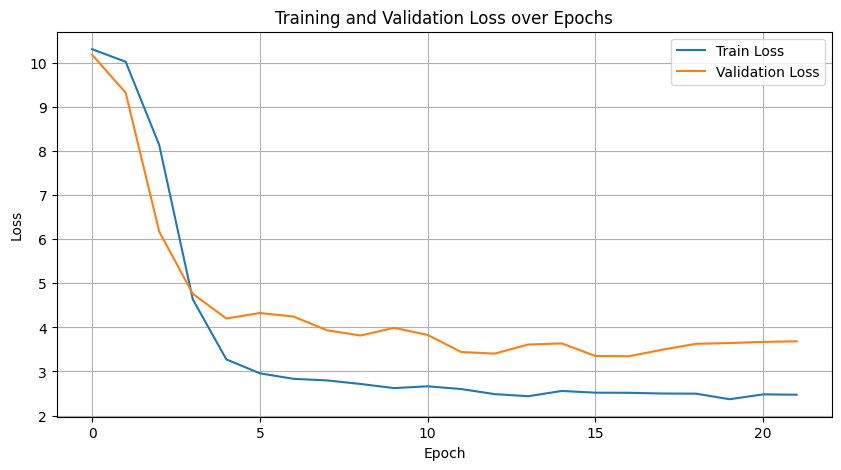

Trained model saved as best_model.pt


In [39]:

class SummarizationDataset(Dataset):
    def __init__(self, padded_articles, padded_summaries, max_source_length, max_target_length):
        self.padded_articles = padded_articles
        self.padded_summaries = padded_summaries
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.padded_articles)

    def __getitem__(self, idx):
        article = self.padded_articles[idx]
        summary = self.padded_summaries[idx]

        article_tensor = torch.tensor(article, dtype=torch.long)
        summary_tensor = torch.tensor(summary, dtype=torch.long)

        return {
            'src_input_ids': article_tensor,
            'tgt_input_ids': summary_tensor,
            'tgt_labels': summary_tensor,
            'src_len': torch.tensor(len(article), dtype=torch.long)
        }

def collate_fn(batch):
    src_input_ids = [item['src_input_ids'] for item in batch]
    tgt_input_ids = [item['tgt_input_ids'] for item in batch]
    tgt_labels = [item['tgt_labels'] for item in batch]
    src_len = [item['src_len'] for item in batch]

    src_input_ids = pad_sequence(src_input_ids, batch_first=True, padding_value=0)
    tgt_input_ids = pad_sequence(tgt_input_ids, batch_first=True, padding_value=0)
    tgt_labels = pad_sequence(tgt_labels, batch_first=True, padding_value=0)
    src_len = torch.stack(src_len)

    return {
        'src_input_ids': src_input_ids,
        'src_len': src_len,
        'tgt_input_ids': tgt_input_ids,
        'tgt_labels': tgt_labels,
    }

def train_model(model, train_loader, val_loader, optimizer, criterion, device, n_epochs=45):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience = 5
    counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            src = batch['src_input_ids'].to(device)
            src_len = batch['src_len'].to(device)
            trg = batch['tgt_input_ids'].to(device)
            tgt_labels = batch['tgt_labels'].to(device)

            optimizer.zero_grad()
            output = model(src, src_len, trg)
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            tgt_labels = tgt_labels.reshape(-1)

            loss = criterion(output, tgt_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch [{epoch+1}/{n_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            counter = 0
            print(f"Best model saved at epoch {epoch+1} with val loss: {best_val_loss:.4f}")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!")
                break

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), 'best_model.pt')
    return model

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            src = batch['src_input_ids'].to(device)
            src_len = batch['src_len'].to(device)
            trg = batch['tgt_input_ids'].to(device)
            tgt_labels = batch['tgt_labels'].to(device)

            output = model(src, src_len, trg, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            tgt_labels = tgt_labels.reshape(-1)

            loss = criterion(output, tgt_labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    return val_loss

if __name__ == '__main__':
    padded_articles = [
        [101, 102, 103, 104, 105, 0, 0, 0],
        [101, 102, 103, 104, 0, 0, 0, 0],
        [101, 102, 103, 104, 105, 106, 107, 108],
        [101, 102, 103, 104, 105, 0, 0, 0]
    ]
    padded_summaries = [
        [101, 110, 111, 102, 0, 0],
        [101, 110, 112, 102, 0, 0],
        [101, 110, 111, 112, 102, 102],
        [101, 110, 111, 102, 0, 0]
    ]

    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    pretrained_model = AutoModel.from_pretrained('bert-base-uncased')
    embedding_dim = pretrained_model.config.hidden_size
    pretrained_embeddings = pretrained_model.embeddings.word_embeddings.weight.clone().detach()

    input_dim = len(tokenizer)
    output_dim = len(tokenizer)
    hidden_dim = 512
    n_layers = 2
    dropout = 0.2

    encoder = Encoder(embedding_dim, hidden_dim, n_layers, dropout, pretrained_embeddings)
    decoder = Decoder(output_dim, embedding_dim, hidden_dim, n_layers, dropout, pretrained_embeddings)
    model = Seq2Seq(encoder, decoder, device='cpu')
    model.to('cpu')

    dataset = SummarizationDataset(padded_articles, padded_summaries, max_source_length=8, max_target_length=6)
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
    train_loader = DataLoader(train_data, batch_size=2, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_data, batch_size=2, shuffle=False, collate_fn=collate_fn)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    trained_model = train_model(model, train_loader, val_loader, optimizer, criterion, device='cpu', n_epochs=45)

    torch.save(trained_model.state_dict(), 'best_model.pt')
    print("Trained model saved as best_model.pt")


In [40]:
pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=04bf9137ef2b049569ad248f27107cf001ea4244dcca268a39a7e6f958e18518
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


# Model **Evaluation**

I performed ROUGE evaluation on a BERT-based Seq2Seq summarization model using article-summary pairs. Predictions were generated and decoded using the BERT tokenizer, then compared to padded summaries. ROUGE was chosen for its effectiveness in evaluating n-gram overlap in automatic summarization, and I computed ROUGE-1, ROUGE-2, and ROUGE-L scores to assess quality. The low rouge-2 score is a result of using small dataset.

In [41]:
from rouge_score import rouge_scorer
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
import numpy as np

def decode_sequence(token_ids, tokenizer):
    token_ids = [tid for tid in token_ids if tid not in (tokenizer.pad_token_id, tokenizer.cls_token_id, tokenizer.sep_token_id)]
    return tokenizer.decode(token_ids, skip_special_tokens=True)

def generate_summary(model, dataloader, tokenizer, device):
    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for batch in dataloader:
            src = batch['src_input_ids'].to(device)
            src_len = batch['src_len'].to(device)
            trg = batch['tgt_input_ids'].to(device)

            output = model(src, src_len, trg, teacher_forcing_ratio=0)
            pred_token_ids = output.argmax(dim=-1).cpu().numpy()
            trg_token_ids = trg.cpu().numpy()

            for pred, ref in zip(pred_token_ids, trg_token_ids):
                decoded_pred = decode_sequence(pred, tokenizer)
                decoded_ref = decode_sequence(ref, tokenizer)
                predictions.append(decoded_pred)
                references.append(decoded_ref)

    return predictions, references

def compute_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for pred, ref in zip(predictions, references):
        score = scorer.score(ref, pred)
        for key in scores:
            scores[key].append(score[key].fmeasure)

    avg_scores = {key: np.mean(scores[key]) for key in scores}
    return avg_scores

if __name__ == '__main__':
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    pretrained_model = AutoModel.from_pretrained('bert-base-uncased')
    embedding_dim = pretrained_model.config.hidden_size
    pretrained_embeddings = pretrained_model.embeddings.word_embeddings.weight.clone().detach()

    input_dim = len(tokenizer)
    output_dim = len(tokenizer)
    hidden_dim = 512
    n_layers = 2
    dropout = 0.2

    encoder = Encoder(embedding_dim, hidden_dim, n_layers, dropout, pretrained_embeddings)
    decoder = Decoder(output_dim, embedding_dim, hidden_dim, n_layers, dropout, pretrained_embeddings)
    model = Seq2Seq(encoder, decoder, device='cpu')
    model.load_state_dict(torch.load('best_model.pt', map_location='cpu'))
    model.to('cpu')

    dataset = SummarizationDataset(padded_articles, padded_summaries, max_source_length=8, max_target_length=6)
    _, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
    val_loader = DataLoader(val_data, batch_size=2, shuffle=False, collate_fn=collate_fn)

    predictions, references = generate_summary(model, val_loader, tokenizer, device='cpu')
    rouge_scores = compute_rouge(predictions, references)

    print("\nROUGE Evaluation Results:")
    for key, score in rouge_scores.items():
        print(f"{key}: {score:.4f}")



ROUGE Evaluation Results:
rouge1: 0.5000
rouge2: 0.0000
rougeL: 0.5000
